## Faster GPU




In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Aug 15 13:12:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## More Memory

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


## NLP with DL

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

pd.set_option('display.max_colwidth', None)

### **Reading Data for Intent Classification**

The data contains various user queries categorized into seven

https://github.com/sonos/nlu-benchmark/tree/master/2017-06-custom-intent-enginesintents

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/classification.csv")
df.head()

text  \
0                         listen to westbam alumb allergic on google music   
1                               add step to me to the 50 clásicos playlist   
2  i give this current textbook a rating value of 1 and a best rating of 6   
3                                     play the song little robin redbreast   
4                     please add iris dement to my playlist this is selena   

          intent  
0      PlayMusic  
1  AddToPlaylist  
2       RateBook  
3      PlayMusic  
4  AddToPlaylist

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14484 entries, 0 to 14483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    14484 non-null  object
 1   intent  14484 non-null  object
dtypes: object(2)
memory usage: 226.4+ KB


In [ ]:
print('df size :', df.shape)

df size : (14484, 2)


In [ ]:
sum(df.duplicated())

# There are 268 duplicated rows in corpus

268

In [ ]:
df=df.drop_duplicates()

# we remove the duplicated rows

In [ ]:
df.isnull().sum()

# There aren't missing values

text      0
intent    0
dtype: int64

In [ ]:
df.reset_index(drop=True, inplace=True)

# We reset the index because we remove duplicated rows.

In [ ]:
df.intent.value_counts()

GetWeather              2086
BookRestaurant          2068
PlayMusic               2064
SearchCreativeWork      2051
AddToPlaylist           2035
RateBook                1991
SearchScreeningEvent    1921
Name: intent, dtype: int64

In [ ]:
df.intent.value_counts(normalize=True)

GetWeather              0.146736
BookRestaurant          0.145470
PlayMusic               0.145189
SearchCreativeWork      0.144274
AddToPlaylist           0.143149
RateBook                0.140053
SearchScreeningEvent    0.135129
Name: intent, dtype: float64

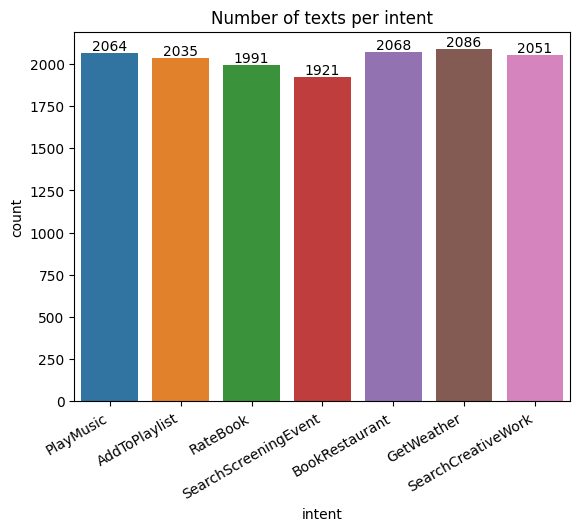

In [ ]:
chart = sns.countplot(x= "intent", data=df)
chart.bar_label(chart.containers[0])
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

## Tokenization

In [ ]:
X = df['text']
y = df['intent']

In [ ]:
num_words = 10001 # we add 1.

tokenizer = Tokenizer(num_words=num_words) #filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n1234567890'
# The Tokenizer function separates all texts into word tokens.

# The num_words hyperparameter indicates that only the first 10,000 words (tokens) that occur most frequently in the corpus will be converted to their
# numeric versions during the tokenization process, while ignoring the other tokens.

# If num_words is assigned None, all words/tokens will be converted to their numeric versions. However, when num_words is set to None, it returns an error
# when providing data to the DL model. Therefore, num_words should always be assigned an integer value. We will discuss the details during the model
# building stage.

# The filters hyperparameter allows us to customize the cleaning operations. If we also want to remove numbers, we can include them in the filters
# hyperparameter.

In [ ]:
tokenizer.fit_on_texts(X)

# fit_on_texts first tokenizes the texts in the corpus and then identifies all unique tokens and assigns them numbers based on their frequency of use.

# The most frequently used token is assigned the number 1.

# Since we have defined num_words=10001, during the conversion process, only the tokens that have numbers between 1 and 10000 will be used, and the others
# will be ignored.

# To be able to see the ranking of the frequency of use of these tokens, we will need to use the word_index function as shown below.

## Creating Word Index

In [ ]:
tokenizer.word_index

# word_index sorts the tokens in the corpus according to their usage frequency.

{'the': 1,
 'a': 2,
 'in': 3,
 'to': 4,
 'for': 5,
 'of': 6,
 'i': 7,
 'at': 8,
 'play': 9,
 'book': 10,
 'is': 11,
 'add': 12,
 'what': 13,
 'my': 14,
 'playlist': 15,
 'find': 16,
 'me': 17,
 'on': 18,
 'this': 19,
 '6': 20,
 'from': 21,
 'movie': 22,
 'rate': 23,
 'and': 24,
 'weather': 25,
 'by': 26,
 'be': 27,
 'show': 28,
 'give': 29,
 'will': 30,
 'restaurant': 31,
 'out': 32,
 'it': 33,
 'want': 34,
 'can': 35,
 'music': 36,
 's': 37,
 'current': 38,
 'stars': 39,
 'forecast': 40,
 'points': 41,
 'playing': 42,
 'like': 43,
 'table': 44,
 'album': 45,
 'movies': 46,
 'song': 47,
 'that': 48,
 'now': 49,
 'need': 50,
 'you': 51,
 'please': 52,
 '1': 53,
 'one': 54,
 'called': 55,
 'with': 56,
 'are': 57,
 'some': 58,
 'd': 59,
 'theatres': 60,
 'schedule': 61,
 'track': 62,
 'reservation': 63,
 'house': 64,
 '2': 65,
 'four': 66,
 '4': 67,
 'time': 68,
 '3': 69,
 'where': 70,
 'get': 71,
 'people': 72,
 '5': 73,
 'two': 74,
 'put': 75,
 'rating': 76,
 'novel': 77,
 'tune': 78,
 

In [ ]:
len(tokenizer.word_index)

#There are a total of 11.763 unique tokens in our corpus.

11763

## Converting tokens to numeric

In [ ]:
X_num_tokens = tokenizer.texts_to_sequences(X)

# The function "texts_to_sequences" converts all tokens in each document/row of our data into numbers according to their usage frequency in the
# word_index (since num_words=10001, only the first 10000 most frequently used tokens will be used).

# Example: The review "I highly advise this music, it is very beautiful." will be converted into the vector [7, 172, 7322, 19, 35, 33, 11, 712, 2776]
# where I: 7, highly: 172, advise: 7322, this: 19, music: 35, it:33, is:11, very:712,  beautiful:2776.

# Remember that these conversions are made according to the first 10,000 most frequently occurring tokens in the corpus. If the "beautiful" token was
# the 10,001st or a larger numbered token, it would be ignored during the conversion and the vector we would get would be [7, 172, 7322, 19, 35, 33, 11, 712].

In [ ]:
X[:2]

0    listen to westbam alumb allergic on google music
1          add step to me to the 50 clásicos playlist
Name: text, dtype: object

In [ ]:
X_num_tokens[:2]

#We see the first two lines as numeric vectors.

[[194, 4, 4718, 4719, 4720, 18, 208, 36], [12, 434, 4, 17, 4, 1, 286, 983, 15]]

## Maximum number of tokens for all documents

In [ ]:
len(X_num_tokens[105])
# The 105th user query consists of 8 tokens.

8

In [ ]:
len(X_num_tokens[106])
# The 106th comment consists of 7 tokens.

7

In [ ]:
len(X_num_tokens[5999])
# The 5999th comment consists of 13 tokens.
# ML/DL models require all data given to them to be in the same dimensions. However, as you can see, the sizes of all lines/documents are different

13

In [ ]:
num_tokens = [len(sen_tokens) for sen_tokens in X_num_tokens]
num_tokens = np.array(num_tokens)

# Firstly, we assign the sizes of all the lines/documnets in the corpus to the variable num_tokens by putting them into a list.

# Since aggregation functions can be applied to arrays in a practical way, we convert the list to an array.

In [ ]:
num_tokens

# We can see how many tokens each line/document consists of.

array([ 8,  9, 16, ...,  8,  8,  7])

In [ ]:
num_tokens.mean()

# We are taking the average of all lines dimensions.

# Can we fix all comments to this number? Or should we choose another number?

8.973832301631964

In [ ]:
num_tokens.max()
# We see that the longest line/document consisted of 35 tokens.

# We need to fix all rows/documents in our corpus to the same size. In fact, it is recommended to fix all documents to 35, which is the length of the longest
# document, to prevent information/token loss in the documents. However, This will come back to us as a computational cost. (Since the rows/documents are not
# too long in our data, you can fix all of them to the size of the longest comment. But what to do in data with very long lines will be shown below with
# an example.)

# If you have very powerful machines, of course, it is most sensible to fix all documents according to the size of the longest document.

# However, if our machines are not powerful, we need to fix rows/documents at smaller sizes. When deciding this, we can determine the number in such a way
# that there will be no information/token loss at rates of 95% and above (or, a token/information loss of 5% or less) in the documents in our corpus.

35

In [ ]:
list = [5, 10, 8, 9, 12, 15]
print(np.array(list) <= 11)
print(sum(np.array(list) <= 11))
print(sum(np.array(list) <= 11)/len(list))

# Example: Let's assume we have 6 rows/documents in our corpus. The first document consists of 5 tokens, the second document consists of 10 tokens,
# the third document consists of 8 tokens, the fourth document consists of 9 tokens, the fifth document consists of 12 tokens and the sixth document
# consists of 15 tokens.

# Let's see how many documents will not lose any information/token if I fix all documents to 11 tokens.

# There will be no loss of any information/token in the first 4 documents, but 1 token will be lost in the 5th document and 4 tokens will be lost in
# the 6th document.

# With the code np.array(list) <= 11, I ensure that when we fix all documents to 11 tokens, the reviews that do not lose information/token are returned True,
# while those that lose information/token are returned False  --> [ True  True  True  True False False].

# With the code sum(np.array(list) <= 11), the Trues are first converted to 1's and Falses to 0's. Then these values are aggregated. The result shows us
# how many documents do not lose any information/token.

# [True  True  True  True False False]--> [1 1 1 1 0 0]--> sum([1 1 1 1 0 0])--> 4 --> No information/token loss in 4 out of 6 documents in my corpus.

# The 4 result we have obtained, when divided by the total number of documents in our corpus (len([5, 10, 8, 9, 12, 15])-->6), returns to us the proportion
# of how many documents do not lose any information/token (4/6 --> 0.67). We want this ratio to be over 95%.

[ True  True  True  True False False]
4
0.6666666666666666


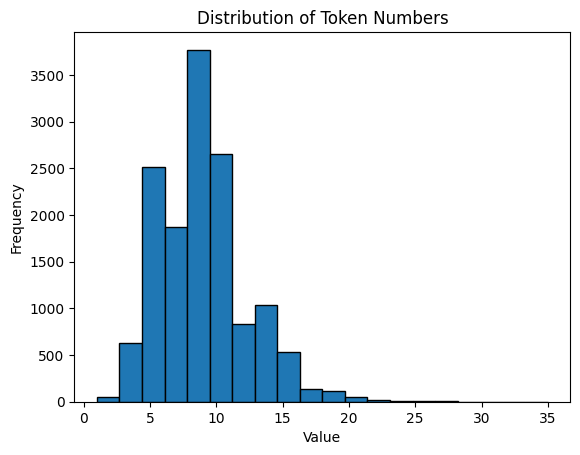

In [ ]:
# Plot a histogram to visualize the distribution
plt.hist(num_tokens, bins=20, edgecolor='black')  # Adjust the number of bins as needed
plt.title("Distribution of Token Numbers")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [ ]:
max_tokens = 21

In [ ]:
sum(num_tokens <= max_tokens) / len(num_tokens)

# In the above example, as we do here, we establish the same equation. And the ratio will be above 95% for which value of max_tokens?

# We are manually ensuring the control of this. By setting it at 21 tokens, I observed that there would be no information/token loss in 99.73% of the
# dokuments in my corpus. Therefore, I will continue with max_tokens = 21.

0.9973269555430501

In [ ]:
sum(num_tokens <= max_tokens)

# When max_tokens is 21, out of a total of 14484 documents in my corpus, there is no information/token loss in 14445 of them.

14178

In [ ]:
len(num_tokens)

# number of all documents/lines in corpus

14216

## Fixing token counts of all documents (pad_sequences)

In [ ]:
X_pad = pad_sequences(X_num_tokens, maxlen=max_tokens, padding="pre")

# padding="pre", paddings and truncating are performed from the beginning.

# padding="post", paddings and truncating are performed from the end.

# Both are tested to see which one yields good results, and it continues with whichever does.

# The numeric versions of the documents and the length to be fixed (maxlength) are given into the pad_sequences function, and all ducuments are fixed to
# 21 tokens.

# This process is called padding. However, don't let the name mislead you; not only the filling process is performed in this operation, but also the truncating
# process.

# Documents with fewer than 21 tokens are padded with 0's to be added at the beginning of the document. For example, a document consisting of 10 tokens is
# filled with an additional 11 0's at the beginning to be fixed to 21 tokens. (if padding="pre")

# Documents with more than 21 tokens have their tokens clipped from the beginning of the document. For example, a document consisting of 31 tokens has its
# first 10 tokens clipped from the beginning to be fixed to 21 tokens. (if padding="pre")

# No addition or clipping is made to a document consisting of 21 tokens. It is left as is.

# We assign the documents, which we fixed to 21 tokens, to the variable X_pad.

In [ ]:
X_pad.shape

# We see that all comments are fixed to 21 tokens.
#We named it X_pad to indicate that it is data subjected to padding process.

(14216, 21)

In [ ]:
X_num_tokens[801]

[29, 17, 1, 61, 5, 81, 46, 8, 1, 108, 93]

In [ ]:
len(X_num_tokens[801])

# We see that the 801th document consists of 11 tokens.

11

In [ ]:
X_pad[801]

# The padding process adds 10 zeros to the beginning of the document to fix it to 21 tokens.

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  29,  17,   1,
        61,   5,  81,  46,   8,   1, 108,  93], dtype=int32)

In [ ]:
np.argmax(num_tokens)

# The longest document in the corpus is located at the 7185th index.

7185

In [ ]:
np.array(X_num_tokens[7185])

# Let's see what happens if we apply padding to  the longest document at the 7258th index in the corpus consisting of 35 tokens.

array([  35,   51,   71,   17,    2,   44, 1830,    5,   80,  574,  926,
         80,  236,   21,   49,    5,  187,   72,    8,    2,  170,  116,
        372,  125,  140,   48,   97,  185,  656,  125,  213,  351,   21,
       8275, 1876])

In [ ]:
X_pad[7185]

# As you can see, the first 14 tokens at the beginning of the document are truncated to be fixed at 21 tokens.

array([  49,    5,  187,   72,    8,    2,  170,  116,  372,  125,  140,
         48,   97,  185,  656,  125,  213,  351,   21, 8275, 1876],
      dtype=int32)

## Converting Labels to Numeric Form (One-Hot Encoding the Labels)

In [ ]:
unique_labels = df['intent'].unique()
unique_labels

# There are a total of 7 unique classes in the target.

array(['PlayMusic', 'AddToPlaylist', 'RateBook', 'SearchScreeningEvent',
       'BookRestaurant', 'GetWeather', 'SearchCreativeWork'], dtype=object)

In [ ]:
label_dict = dict()

for i, label in enumerate(unique_labels):
    label_dict[label] = i

label_dict

# We need to convert the unique classes in our target into numeric version first, and then convert them into a matrix.
# First, we determine which classes will be assigned to which numbers.

{'PlayMusic': 0,
 'AddToPlaylist': 1,
 'RateBook': 2,
 'SearchScreeningEvent': 3,
 'BookRestaurant': 4,
 'GetWeather': 5,
 'SearchCreativeWork': 6}

In [ ]:
df.head()

text  \
0                         listen to westbam alumb allergic on google music   
1                               add step to me to the 50 clásicos playlist   
2  i give this current textbook a rating value of 1 and a best rating of 6   
3                                     play the song little robin redbreast   
4                     please add iris dement to my playlist this is selena   

          intent  
0      PlayMusic  
1  AddToPlaylist  
2       RateBook  
3      PlayMusic  
4  AddToPlaylist

In [ ]:
df['intent'] = df['intent'].map(label_dict)
df.head()

# We assign numbers to classes according to the label_dict using the map function

text  \
0                         listen to westbam alumb allergic on google music   
1                               add step to me to the 50 clásicos playlist   
2  i give this current textbook a rating value of 1 and a best rating of 6   
3                                     play the song little robin redbreast   
4                     please add iris dement to my playlist this is selena   

   intent  
0       0  
1       1  
2       2  
3       0  
4       1

In [ ]:
y.head()

0        PlayMusic
1    AddToPlaylist
2         RateBook
3        PlayMusic
4    AddToPlaylist
Name: intent, dtype: object

In [ ]:
y=df.intent
y.head()

# We assign the numeric version of the target to the "y" variable.

0    0
1    1
2    2
3    0
4    1
Name: intent, dtype: int64

In [ ]:
from tensorflow.keras.utils import to_categorical

to_categorical(y, 7)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_new = to_categorical(y, 7)
y_new

# We convert y, which we have transformed into numeric version, into a matrix in one-hot-encoder format using the to_categorical function.

# We provide our target and the number of unique classes to the to_categorical function.

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_new, test_size=0.1, stratify=y, random_state=42)

## Modelling

In [ ]:
model = Sequential()

# This function represents a model where layers follow each other sequentially, meaning the outputs of one layer are fed into the next layer.
# The Sequential model includes the layers that receive inputs from the previous layer.
# Layers are added to the Sequential model using the add method.

In [ ]:
embedding_size = 50

# We specify the dimensionality/size of each vector for the tokens that we will provide to the DL model.

# Although best practice usually prefers numbers like 50, 100, 300, you can choose any number you want. However, the larger this number is, the higher
# the computational cost will be for us.

**Recommended Neuron Number in ANN Models**

There are several different approaches to planning the number of neurons in a deep learning model with multiple hidden layers (ANN).

**Decreasing number of neurons:** More neurons are used in the first hidden layer and the number of neurons is reduced in each subsequent layer. In this approach, it is thought that more features are learned in the earlier layers and fewer feature are learned in the later layers.

**Fixed number of neurons:** The same number of neurons is used in each layer. In this approach, it is thought that each layer has the same importance.

**Increasing number of neurons:** Fewer neurons are used in the first hidden layer and the number of neurons is increased in each subsequent layer. In this approach, it is thought that more features are learned in the later layers.

It is recommended to do trial and error to find the best among these methods. Also, in order to understand the effects of the number of hidden layers, the number of neurons, optimization functions, batch size, etc. hyperparameters, it is necessary to choose the best by doing experiments.

As a hypothesis, it can be said that using more neurons in the first layers may cause to cover a wider feature area and thus learn the features better. However, since it may not always be the best option for performance, it is recommended that you try them all with your experiments and achieve the best result.

**Recommended Neuron Number in RNN Models:**

**Decreasing number of neurons:** More neurons are used in the first LSTM&GRU layer and the number of neurons is reduced in each subsequent layer. This approach allows more features to be learned in earlier layers and fewer features to be learned in later layers.

As a best practice, the recommended number of neurons for the first layer is the same as the size of the word embedding we give to the model. If the word embedding consists of 50 elements, the number of neurons in the first layer should start with 50 and decrease gradually. However, you need to experiment to determine which neuron number gives you the best result.

**return_sequences hyperparameter**

If the "return_sequences" hyperparameter of LSTM and GRU layers is set to True, all hidden states at the time steps shown below are fed to the next LSTM/GRU layer. If it is set to False, only the last hidden state is fed to the next layer.

If the layer following an LSTM/GRU layer is another LSTM/GRU layer, the "return_sequences" hyperparameter must be set to True, otherwise the model will not work and will return an error.

If the layer following an LSTM/GRU layer is a Dense layer, the "return_sequences" hyperparameter must be set to False, otherwise the model will not work and will return an error.

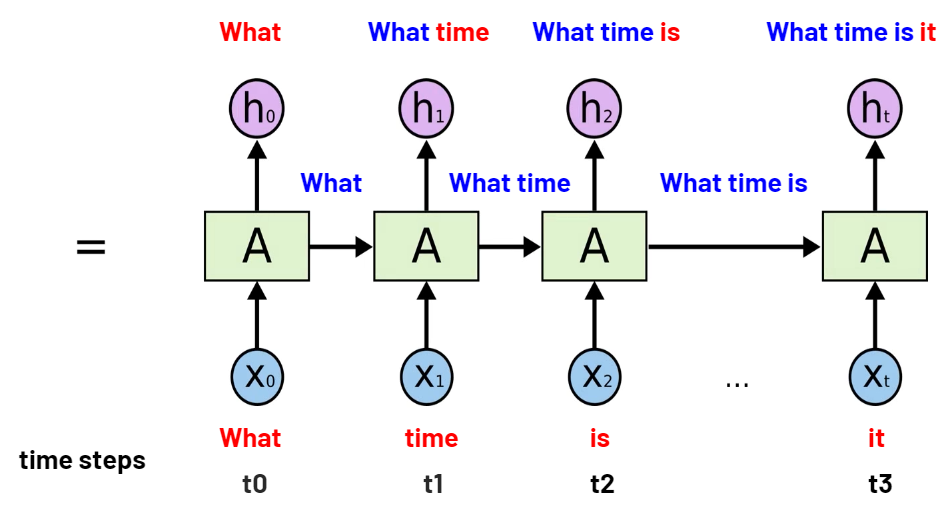

In [ ]:
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens))

# The Embedding layer is a layer used in NLP models and consists of a 3-dimensional tensor.
# The first dimension is the total number of tokens in the training set.
# The second dimension is how many tokens each document consists of (max_tokens).
# The third dimension is how many elements a word embedding for each token consists of (embedding_size).

# When converting documents to a numeric version, since the first 10,000 tokens most frequently used in the corpus are used, we make the
# input_dim=num_words adjustment to the Embedding layer so that only the first 10,000 tokens most frequently used in the corpus are used in both training and
# prediction stages.

# If you make the input_dim smaller than 10,000 (like 5,000), then the model trains and predicts using only the first 5,000 tokens most frequently
# used in the corpus.

model.add(Dropout(0.2))

model.add(GRU(units=50, return_sequences=True))

# return_sequences=False makes the model transfer only the last time step's (t_n) hidden_state to the next layer. The default is False.

# return_sequences=True makes the model transfer all hidden_states from all time steps (like t_0, t_1, t_2 .....t_n) to the next LSTM, GRU layers.
# This way, the model tries to keep the entire sentence in mind. If an LSTM/GRU layer is followed by another LSTM/GRU layer, return_sequences should be set
# to True, otherwise the model will return an error. However, if the next layer is a dense layer, return_sequences should be set to False, otherwise
# the model will again return an error. This is because Dense layers only work with a single hidden_state.

model.add(GRU(units=25, return_sequences=True))
model.add(Dropout(0.2))
# We set return_sequences=True because the next layer is a GRU layer.

model.add(GRU(units=12, return_sequences=False))
# We set return_sequences=False because the next layer is a Dense layer.


model.add(Dense(7, activation='softmax'))  # There are 7 classes

In [ ]:
# The rate specified during the dropout process indicates how many neurons will be shut down on average. For instance, during the dropout(0.5) process,
# 50% of the neurons are randomly shut down in each iteration. However, this rate may not be exactly the same in each iteration. For example,
# it could be 0.3 in one iteration and 0.7 in another, but the average will always be 0.5.

# Therefore, the rate can vary in each iteration as you might expect.

In [ ]:
optimizer = Adam(learning_rate=0.008)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['Recall'])

# The compile is where we adjust the optimization parameters. Compile parameters include the choice of gradient descent algorithm to be used in
# the optimization processes of the DL model, the determination of the loss function, and the metrics to be followed during optimization processes.
# The details are as follows.

# loss: The loss function to be used for optimizing the model. For example, for classification: binary_crossentropy or categorical_crossentropy,
# for regression: mse, etc.
# optimizer: The optimization algorithm to be used to optimize the model's weights. For example, SGD, Adam, or RMSprop, etc.
# metrics: The metrics to be used to evaluate the model's performance. For example, accuracy, precision, or recall, etc.

In [ ]:
model.summary()
# embedding_size * num_words ==> 50 * 10001 ==> 500050

# 3 x (n2 + nm + 2n) m= input, n= output
# (50*50 + 50*50 + 2*50)*3 = 15300  ==> m = 50, n = 50
# (25*25 + 50*25 + 2*25)*3 = 5775   ==> m = 50, n = 25
# (12*12 + 25*12 + 2*12)*3 = 1404   ==> m = 24, n = 12
# 12*7 + 7 = 91

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 50)            500050    
                                                                 
 dropout (Dropout)           (None, 21, 50)            0         
                                                                 
 gru (GRU)                   (None, 21, 50)            15300     
                                                                 
 gru_1 (GRU)                 (None, 21, 25)            5775      
                                                                 
 dropout_1 (Dropout)         (None, 21, 25)            0         
                                                                 
 gru_2 (GRU)                 (None, 12)                1404      
                                                                 
 dense (Dense)               (None, 7)                 9

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_recall", mode="max", verbose=1,
                           patience = 2, restore_best_weights=True)

In [ ]:
#from sklearn.utils import class_weight
#classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
#pd.Series(classes_weights).unique()

# If our data were unbalanced, we could have used sample weights here

In [ ]:
model.fit(X_train, y_train, epochs=20, batch_size=32,       #sample_weight= classes_weights
         validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/20
400/400 [==============================] - 30s 46ms/step - loss: 0.2779 - recall: 0.8886 - val_loss: 0.1265 - val_recall: 0.9662
Epoch 2/20
400/400 [==============================] - 5s 13ms/step - loss: 0.0711 - recall: 0.9801 - val_loss: 0.1003 - val_recall: 0.9726
Epoch 3/20
400/400 [==============================] - 5s 13ms/step - loss: 0.0422 - recall: 0.9877 - val_loss: 0.1101 - val_recall: 0.9684
Epoch 4/20
400/400 [==============================] - 4s 11ms/step - loss: 0.0296 - recall: 0.9919 - val_loss: 0.1130 - val_recall: 0.9754
Epoch 5/20
400/400 [==============================] - 5s 12ms/step - loss: 0.0229 - recall: 0.9943 - val_loss: 0.1094 - val_recall: 0.9768
Epoch 6/20
400/400 [==============================] - 4s 10ms/step - loss: 0.0184 - recall: 0.9942 - val_loss: 0.1472 - val_recall: 0.9599
Epoch 7/20
400/400 [==============================] - 4s 9ms/step - loss: 0.0227 - recall: 0.9937 - val_loss: 0.1390 - val_recall: 0.9726
Epoch 7: early stopping


## Model evaluation

In [ ]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

loss    recall  val_loss  val_recall
0  0.277937  0.888620  0.126455    0.966245
1  0.071093  0.980069  0.100264    0.972574
2  0.042250  0.987650  0.110104    0.968354
3  0.029604  0.991949  0.112990    0.975387
4  0.022905  0.994294  0.109404    0.976793

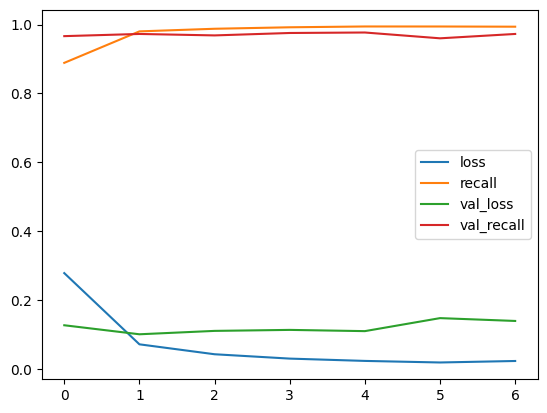

In [ ]:
model_loss.plot();

In [ ]:
model.evaluate(X_test, y_test)

45/45 [==============================] - 0s 4ms/step - loss: 0.1094 - recall: 0.9768


[0.10940364003181458, 0.9767932295799255]

In [ ]:
model.evaluate(X_train, y_train)

400/400 [==============================] - 2s 6ms/step - loss: 0.0117 - recall: 0.9973


[0.011707506142556667, 0.9973425269126892]

In [ ]:
# y_pred = model3.predict(X_test) >= 0.5

# print(confusion_matrix(y_test, y_pred))
# print("-------------------------------------------------------")
# print(classification_report(y_test, y_pred))

# If our data were binary data, we would use these codes.

In [ ]:
y_pred = model.predict(X_test)

45/45 [==============================] - 1s 4ms/step


In [ ]:
y_pred

array([[1.40571879e-04, 1.83597749e-05, 6.00491285e-06, ...,
        1.14980401e-04, 9.99644756e-01, 7.23232915e-07],
       [2.64705368e-03, 7.32894080e-07, 1.37906172e-04, ...,
        3.39695107e-04, 1.98614621e-03, 9.09271929e-03],
       [5.52953061e-05, 1.53621964e-04, 9.99713480e-01, ...,
        8.60713172e-08, 1.24369180e-05, 1.60830295e-05],
       ...,
       [1.10958827e-04, 5.52109414e-05, 1.86262303e-04, ...,
        1.65720194e-05, 1.04133528e-06, 9.99306440e-01],
       [1.26718589e-06, 1.43650832e-04, 1.12663395e-06, ...,
        9.99209285e-01, 4.79304232e-04, 1.00365774e-04],
       [1.20526318e-04, 5.80651322e-05, 1.92634849e-04, ...,
        1.55500275e-05, 9.87588237e-07, 9.99299407e-01]], dtype=float32)

In [ ]:
y_prediction =  [np.argmax(i) for i in y_pred]
y_prediction[:3]

# In order for confusion_matrix and classification_report to work, y_test and y_pred need to be converted from 2-dimensional tensors (matrix) to
# 1-dimensional tensors (vectors).

# The code [np.argmax(i) for i in y_pred] is used to determine the index numbers with the highest probability values in each row of the y_pred matrix.
# These index numbers also represent the classes predicted by the model.

# The first 3 classes predicted by the model are shown below.

[5, 3, 2]

In [ ]:
y_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
y_test_new = [np.argmax(i) for i in y_test]
y_test_new [:3]

# In order for confusion_matrix and classification_report to work, y_test and y_pred need to be converted from 2-dimensional tensors (matrix) to
# 1-dimensional tensors (vectors).

# the code [np.argmax(i) for i in y_test] determines the index numbers of the values that are equal to 1 in each row of the y_test matrix, which is in
# one-hot encoder format. These index numbers also represent the actual classes of the target.

[5, 3, 2]

In [ ]:
y_pred_train = model.predict(X_train)

400/400 [==============================] - 1s 3ms/step


In [ ]:
y_prediction_train =  [np.argmax(i) for i in y_pred_train]
y_prediction_train[:3]

# We are performing the same operations on the training data as we did on the test data above.

[4, 4, 4]

In [ ]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_train_new = [np.argmax(i) for i in y_train]
y_train_new [:3]

# We are performing the same operations on the training data as we did on the test data above.

[4, 4, 4]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score

print(confusion_matrix(y_test_new, y_prediction))
print("-------------------------------------------------------")
print(classification_report(y_test_new, y_prediction))

# After converting the "y_test" matrix to "y_test_new" vector and the "y_pred" matrix to "y_prediction" vector, we can run the confusion_matrix
# and classification_report.

[[201   0   0   0   0   0   5]
 [  0 204   0   0   0   0   0]
 [  0   0 197   0   0   0   2]
 [  0   0   0 182   0   0  10]
 [  0   0   0   1 205   0   1]
 [  0   0   0   0   1 208   0]
 [  5   0   3   2   1   0 194]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       206
           1       1.00      1.00      1.00       204
           2       0.98      0.99      0.99       199
           3       0.98      0.95      0.97       192
           4       0.99      0.99      0.99       207
           5       1.00      1.00      1.00       209
           6       0.92      0.95      0.93       205

    accuracy                           0.98      1422
   macro avg       0.98      0.98      0.98      1422
weighted avg       0.98      0.98      0.98      1422



In [ ]:
print(confusion_matrix(y_train_new, y_prediction_train))
print("-------------------------------------------------------")
print(classification_report(y_train_new, y_prediction_train))

# After converting the "y_train" matrix to "y_train_new" vector and the "y_pred_train" matrix to "y_prediction_train" vector, we can run the confusion_matrix
# and classification_report.

[[1854    1    0    0    0    0    3]
 [   2 1825    0    0    0    0    4]
 [   0    0 1792    0    0    0    0]
 [   0    0    0 1721    0    0    8]
 [   0    0    0    1 1860    0    0]
 [   0    0    0    1    6 1870    0]
 [   4    0    0    2    1    0 1839]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1858
           1       1.00      1.00      1.00      1831
           2       1.00      1.00      1.00      1792
           3       1.00      1.00      1.00      1729
           4       1.00      1.00      1.00      1861
           5       1.00      1.00      1.00      1877
           6       0.99      1.00      0.99      1846

    accuracy                           1.00     12794
   macro avg       1.00      1.00      1.00     12794
weighted avg       1.00      1.00      1.00     12794



In [ ]:
!pip install scikit-plot

45/45 [==============================] - 0s 3ms/step


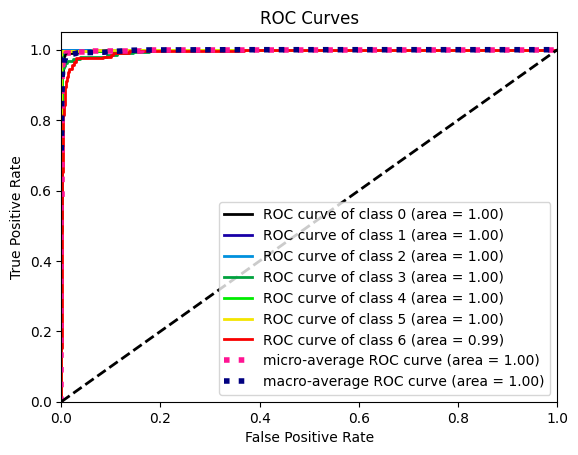

In [ ]:
from scikitplot.metrics import plot_roc, plot_precision_recall

y_pred_proba = model.predict(X_test)

plot_roc(y_test_new, y_pred_proba) # y_test must be vector format and y_pred_proba must be matrix fromat
plt.show();

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test_new, y_pred_proba, multi_class='ovr') # multi_class parameter must be "ovr" or "ovo"

0.9981396168981149

## Model Saving

In [ ]:
model.save('/content/drive/MyDrive/intent_classifier_deep_learning.h5')

##Loading Model

In [ ]:
from tensorflow.keras.models import load_model
model_review = load_model('/content/drive/MyDrive/intent_classifier_deep_learning.h5')

## Predicton

In [ ]:
text1 = "please play the most popular songs"
text2 = "I will give 0 star to the book I am reading now"
text3 = "Find me the best movies"
text4 = "I'd like to watch the best actor movie"
text5 = "Need to make a reservation for 4."

reviews = [text1, text2, text3, text4, text5]

In [ ]:
tokens = tokenizer.texts_to_sequences(reviews)

# "First, we convert the texts we will predict into a numeric version based on the top 10,000 tokens used in our training data. Since the conversions
# are made based on the top 10,000 tokens used in the training data, any tokens outside of the top 10,000 will be ignored during the prediction phase.

In [ ]:
tokens

[[52, 9, 1, 295, 157, 130],
 [7, 30, 29, 94, 237, 4, 1, 10, 7, 95, 1112, 49],
 [16, 17, 1, 111, 46],
 [43, 4, 123, 1, 111, 22],
 [50, 4, 176, 2, 63, 5, 67]]

In [ ]:
max_tokens = 21
tokens_pad = pad_sequences(tokens, maxlen=max_tokens, padding="pre")
tokens_pad.shape

# We fix all texts to 21 tokens, just like in the train data.

(5, 21)

In [ ]:
probs = model.predict(tokens_pad)
probs

1/1 [==============================] - 0s 22ms/step


array([[9.9513537e-01, 1.1315383e-03, 5.3103395e-05, 3.8431340e-04,
        1.1625431e-05, 3.1617010e-04, 2.9680054e-03],
       [3.1502059e-05, 1.6797672e-03, 9.4804949e-01, 6.0759205e-03,
        3.7518490e-02, 4.6013440e-03, 2.0435764e-03],
       [2.5279514e-04, 8.4810403e-05, 2.0630845e-04, 9.9519664e-01,
        5.7168683e-04, 3.0805884e-05, 3.6569030e-03],
       [4.8416000e-02, 1.6376099e-02, 4.8541809e-03, 2.8447440e-01,
        2.7336829e-04, 2.4284900e-05, 6.4558160e-01],
       [2.0781342e-06, 7.6292673e-07, 1.1893693e-04, 7.4672309e-04,
        9.9750596e-01, 1.2695350e-03, 3.5601747e-04]], dtype=float32)

In [ ]:
classes = []
probas = []
for i in probs:
    classes.append(np.argmax(i))
    probas.append(max(i))

# We determine the predicted classes using the index number of the maximum value of probabilities in each row, and we determine with what probability
# the model predicted those classes using the highest probability value.

In [ ]:
my_dict = {"Review":reviews, "prob":probas, "classes":classes}

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame(my_dict)

Review      prob  classes
0               please play the most popular songs  0.995135        0
1  I will give 0 star to the book I am reading now  0.948049        2
2                          Find me the best movies  0.995197        3
3           I'd like to watch the best actor movie  0.645582        6
4                Need to make a reservation for 4.  0.997506        4

In [ ]:
"""
{'PlayMusic': 0,
 'AddToPlaylist': 1,
 'RateBook': 2,
 'SearchScreeningEvent': 3,
 'BookRestaurant': 4,
 'GetWeather': 5,
 'SearchCreativeWork': 6}
 """